In [1]:
import torchvision.datasets
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [21]:
#dataset_train = torchvision.datasets.Kitti('./data', train=True, download=True)
#dataset_test = torchvision.datasets.Kitti('./data', train=False, download=True)

import huggingface_hub
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("EduardoPacheco/FoodSeg103")

1st let's visualize the 1st top images to wee what are looking at

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2135
    })
})

In [4]:
from going_modular.HF_UTILITY import plot_first_10_images, plot_first_10_label

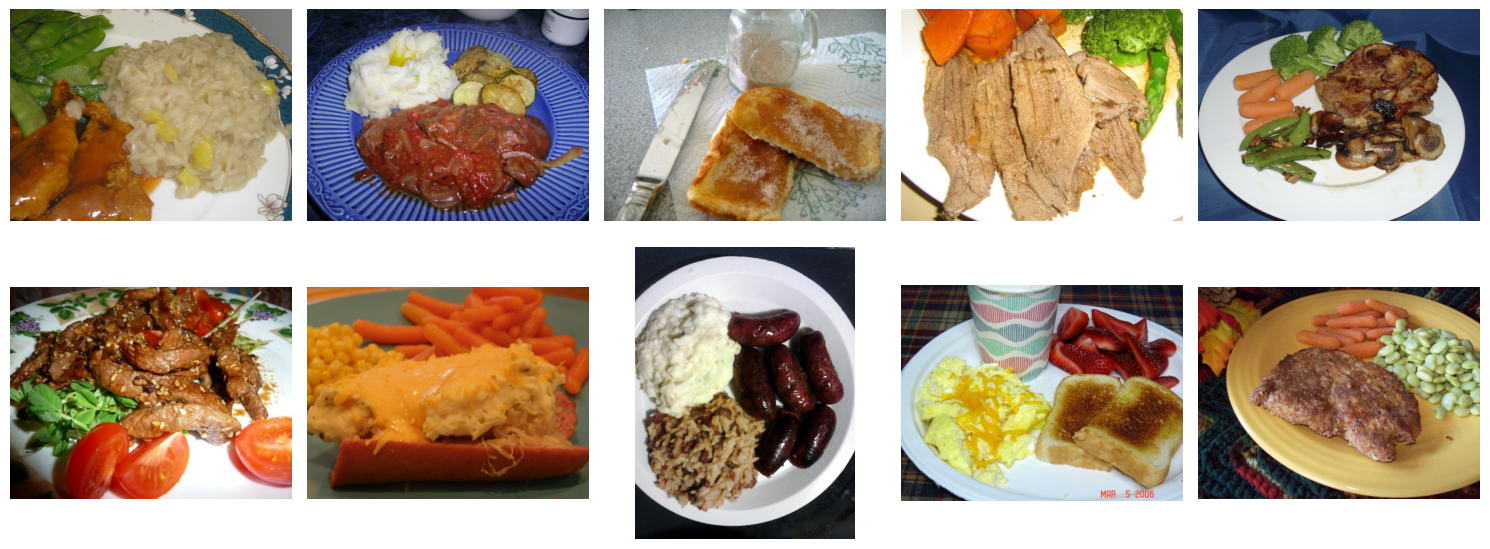

In [5]:
plot_first_10_images(dataset)

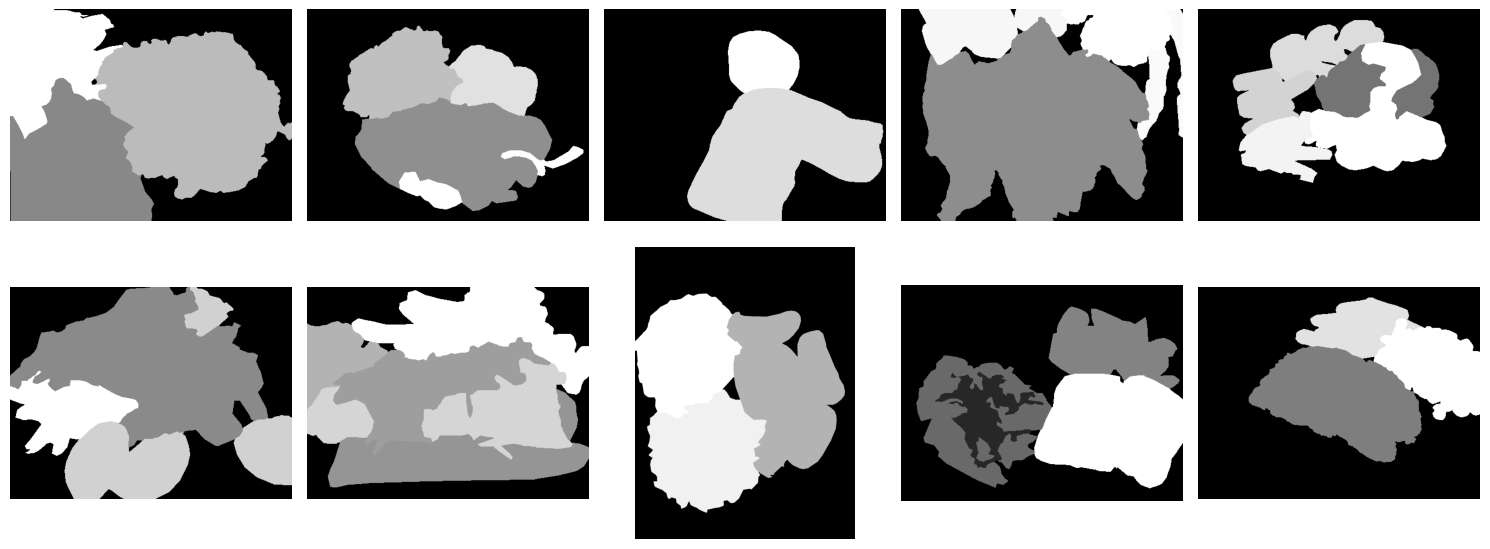

In [6]:
plot_first_10_label(dataset)

Now i have verified the integrity of all the folders and that the images are this. Now lets lists all the images and their id elements

In [7]:
# understand how to get the json file from the dataset object
# got from 'https://huggingface.co/datasets/EduardoPacheco/FoodSeg103/resolve/main/id2label.json?download=true'
id2label = {"0": "background", "1": "candy", "2": "egg tart", "3": "french fries", "4": "chocolate", "5": "biscuit", "6": "popcorn", "7": "pudding", "8": "ice cream", "9": "cheese butter", "10": "cake", "11": "wine", "12": "milkshake", "13": "coffee", "14": "juice", "15": "milk", "16": "tea", "17": "almond", "18": "red beans", "19": "cashew", "20": "dried cranberries", "21": "soy", "22": "walnut", "23": "peanut", "24": "egg", "25": "apple", "26": "date", "27": "apricot", "28": "avocado", "29": "banana", "30": "strawberry", "31": "cherry", "32": "blueberry", "33": "raspberry", "34": "mango", "35": "olives", "36": "peach", "37": "lemon", "38": "pear", "39": "fig", "40": "pineapple", "41": "grape", "42": "kiwi", "43": "melon", "44": "orange", "45": "watermelon", "46": "steak", "47": "pork", "48": "chicken duck", "49": "sausage", "50": "fried meat", "51": "lamb", "52": "sauce", "53": "crab", "54": "fish", "55": "shellfish", "56": "shrimp", "57": "soup", "58": "bread", "59": "corn", "60": "hamburg", "61": "pizza", "62": " hanamaki baozi", "63": "wonton dumplings", "64": "pasta", "65": "noodles", "66": "rice", "67": "pie", "68": "tofu", "69": "eggplant", "70": "potato", "71": "garlic", "72": "cauliflower", "73": "tomato", "74": "kelp", "75": "seaweed", "76": "spring onion", "77": "rape", "78": "ginger", "79": "okra", "80": "lettuce", "81": "pumpkin", "82": "cucumber", "83": "white radish", "84": "carrot", "85": "asparagus", "86": "bamboo shoots", "87": "broccoli", "88": "celery stick", "89": "cilantro mint", "90": "snow peas", "91": " cabbage", "92": "bean sprouts", "93": "onion", "94": "pepper", "95": "green beans", "96": "French beans", "97": "king oyster mushroom", "98": "shiitake", "99": "enoki mushroom", "100": "oyster mushroom", "101": "white button mushroom", "102": "salad", "103": "other ingredients"}

In [27]:
import numpy as np
image = dataset["train"][0]["image"]
label = dataset["train"][0]["label"]
# Assuming you have a numpy array called 'array'
print("Shape input: {}".format(np.array(image).shape))
print("Shape label: {}".format(np.array(label).shape))

Shape input: (384, 512, 3)
Shape label: (384, 512)


### DataLoader

Loading the dataset into the dataloader so things can be smoother -> 1st let try the transform for one single image

In [8]:
image = dataset["train"][0]["image"]
mask = np.array(dataset["train"][0]["label"])
type(mask)

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 512)
(512, 512)


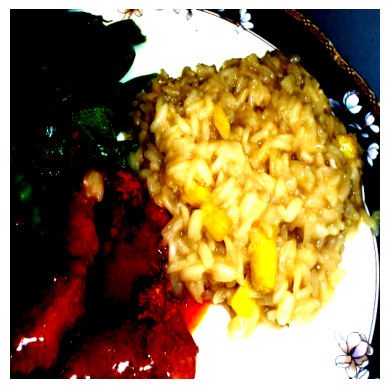

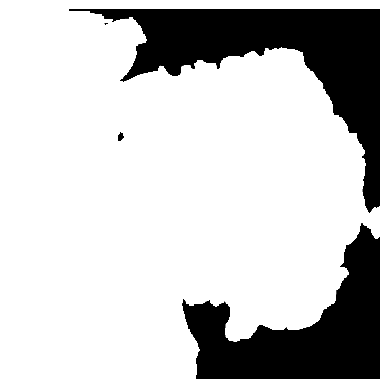

In [10]:
import albumentations as A
from going_modular.HF_UTILITY import plot_image_numpy, plot_mask_numpy
import torch

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

transformed = transform(image=np.array(image), mask=mask)
pixel_values = np.moveaxis(transformed["image"], -1, 0)
instance_seg_transformed = transformed["mask"]
print(pixel_values.shape)
print(instance_seg_transformed.shape)
plot_image_numpy(pixel_values)
plot_mask_numpy(instance_seg_transformed)

In [11]:
np.array(dataset["train"][0]["label"]).shape

(384, 512)

In [12]:
import torch
from torch.utils.data import DataLoader

# Define the dataset and transform
dataset = dataset["train"]
transform = transform

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Iterate over one batch of inputs and outputs
for batch in dataloader:
    inputs = batch["image"]
    masks = batch["label"]
    
    # Apply the transform to the inputs and masks
    transformed_inputs = transform(image=inputs.squeeze(0).numpy())["image"]
    transformed_masks = transform(image=masks.squeeze(0).numpy())["image"]
    
    # Convert the transformed inputs and masks to tensors
    transformed_inputs = torch.from_numpy(transformed_inputs).unsqueeze(0)
    transformed_masks = torch.from_numpy(transformed_masks).unsqueeze(0)
    
    # Print the inputs and masks
    print("Inputs:", transformed_inputs)
    print("Masks:", transformed_masks)
    break  # Only show one iteration


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

In [25]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):

        #image = np.array(self.dataset[idx]["image"].convert("RGB"))
        image = np.array(self.dataset[idx]["image"])
        instance_seg = np.array(self.dataset[idx]["label"])
        """      
        class_id_map = np.array(self.dataset[idx]["label"])[:,:]
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})
        """
        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']
            # convert to C, H, W
            #image = image.transpose(2,0,1)


In [26]:
ds_train = ImageSegmentationDataset(dataset["train"], transform=transform)
ds_test = ImageSegmentationDataset(dataset["validation"], transform=transform)

In [31]:
type(ds_train)

__main__.ImageSegmentationDataset

In [23]:
inputs = ds_train[0]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

AttributeError: 'NoneType' object has no attribute 'items'

In [35]:
# Loading the data into the dataloader as in interable, but this is not important right now
examples = enumerate(dataloader_train)
batch_idx, data = next(examples)

output = network(example_data)
print("Example of the INPUT of Image Classification: \n {}  --> [ColorChannels, Height, Width] \n in the data type: {}".format(example_data.shape, type(example_data)))
print("\nExample of the OUTPUT of Image Classification: \n {}  --> [ColorChannels, Height, Width] \n in the data type: {}".format(output.shape, type(output)))


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

### Model SegNet
Importing the SegNet model used to train on the Dataset

In [ ]:
from going_modular.Models import SegNet
in_chn = 3
out_chn = 103  # number of labels
bn_momentum = 0.5
model = SegNet(in_chn=in_chn, out_chn=out_chn, BN_momentum=bn_momentum)

Let's try and apply to the model one singe image and see what it returns

In [ ]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
# Torch needs to be precise intructions when you send the CPU OR GPU
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [ ]:
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

In [ ]:
ds_train[0]["image"]

tensor([[[ 34,  60,  61],
         [ 32,  56,  60],
         [ 32,  53,  58],
         ...,
         [121, 125, 124],
         [121, 125, 124],
         [122, 126, 125]],

        [[ 30,  51,  54],
         [ 27,  46,  50],
         [ 24,  44,  45],
         ...,
         [122, 126, 125],
         [123, 127, 126],
         [125, 129, 128]],

        [[ 29,  47,  47],
         [ 29,  45,  44],
         [ 29,  46,  38],
         ...,
         [124, 126, 125],
         [126, 128, 127],
         [128, 130, 129]],

        ...,

        [[ 69,  39,   3],
         [ 66,  36,   2],
         [ 61,  34,   4],
         ...,
         [ 26,  64,  75],
         [ 34,  66,  81],
         [ 41,  68,  87]],

        [[ 45,  28,   8],
         [ 44,  27,   9],
         [ 42,  27,   8],
         ...,
         [ 58,  88,  90],
         [ 75,  92, 100],
         [ 73,  81,  92]],

        [[ 42,  23,  16],
         [ 43,  24,  17],
         [ 44,  25,  18],
         ...,
         [149, 165, 164],
        

OK, now the problem is to understand whar the SEGNET wants as an input and the precise shape which it desires ! 

In [ ]:

model.eval()
to_device(model)
print("Input Shape of the Image: {}".format(ds_train[0]["image"].shape))
output = model(to_device(ds_train[0]["image"])).shape
print("Output Shape of the Image: {}".format(output))
# why the output is 3 ?

Input Shape of the Image: torch.Size([384, 512, 3])


RuntimeError: Input type (unsigned char) and bias type (float) should be the same